# Movie Classification Team 11

# EDA and Plot Transformations

### Team Members:
Andrew Lund, Nicholas Morgam, Amay Umradia, Charles Webb

**The purpose of this notebook is two-fold:**
1. To explore the dataset we have built with TMDB and IMDB movie data on 1000 movies. We will primarily be exploring plot and genre information since that is the primary focus of this project: Predicting genres from plots. 
2. To apply bag-of-words with TFIDF and word2vec plot transformations of the TMDB, IMDB, and combined plots.

In [1]:
#import libraries and set seaborn styling
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tmdbsimple as tmdb
import requests
import pandas as pd
import time
import numpy as np
from ast import literal_eval
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
sns.set_context('talk')
sns.set_style('ticks')

C:\Users\A706GZZ\Documents\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


---
# EDA
#### GET TMDB genre labels for reference

We will be using the TMDB genres as our response variable throughout this project. The analysis for these plots can be found in our Milestone 3 and Final Report documents located in this repository's 'submissions' directory.

In [2]:
import json
id_to_genre = json.load(open('data/id_to_genre.json'))

id_to_genre = {int(key):value for key, value in id_to_genre.items()} #convert string keys to int keys
id_to_genre

{12: 'Adventure',
 14: 'Fantasy',
 16: 'Animation',
 18: 'Drama',
 27: 'Horror',
 28: 'Action',
 35: 'Comedy',
 36: 'History',
 37: 'Western',
 53: 'Thriller',
 80: 'Crime',
 99: 'Documentary',
 878: 'Science Fiction',
 9648: 'Mystery',
 10402: 'Music',
 10749: 'Romance',
 10751: 'Family',
 10752: 'War',
 10770: 'TV Movie'}

#### Read in our scraped movie data

The "movies" dataframe below includes some of the plot transformations further along in this notebook since we have manipulated and saved our scraped data multiple times throoughout the duration of this project.

In [3]:
movies = pd.read_csv('data/movies.csv', encoding='utf-8', converters={'tmdb_genres':literal_eval})

movies.release_date = pd.to_datetime(movies.release_date)
movies.head()

,tmdb_id,imdb_id,tmdb_genres,tmdb_plot,imdb_plot,popularity,release_date,title,vote_average,vote_count
0,278,tt0111161,"[18, 80]",Framed in the 1940s for the double murder of h...,Chronicles the experiences of a formerly succe...,34.346733,1994-09-23,The Shawshank Redemption,8.6,9913
1,238,tt0068646,"[18, 80]",Spanning the years 1945 to 1955 a chronicle o...,When the aging head of a famous crime family d...,39.079220,1972-03-14,The Godfather,8.5,7479
2,424,tt0108052,"[18, 36, 10752]",The true story of how businessman Oskar Schind...,Oskar Schindler is a vainglorious and greedy G...,21.613388,1993-11-29,Schindler's List,8.4,5626
3,240,tt0071562,"[18, 80]",In the continuing saga of the Corleone crime f...,The continuing saga of the Corleone crime fami...,34.872781,1974-12-20,The Godfather: Part II,8.4,4331
4,680,tt0110912,"[53, 80]",A burger loving hit man his philosophical par...,Jules Winnfield Samuel L Jackson and Vincen...,39.663864,1994-09-10,Pulp Fiction,8.3,11076


#### Print a movie title and its TMDB and IMDB plot for comparison

In [4]:
print('Title:\n', movies.title[12],
      '\n\nTMDB Plot:\n', movies.tmdb_plot[12], 
      '\n\nIMDB Plot:\n', movies.imdb_plot[12])

Title:
 Forrest Gump 

TMDB Plot:
 A man with a low IQ has accomplished great things in his life and been present during significant historic events   in each case  far exceeding what anyone imagined he could do  Yet  despite all the things he has attained  his one true love eludes him   Forrest Gump  is the story of a man who rose above his challenges  and who proved that determination  courage  and love are more important than ability  

IMDB Plot:
 Forrest Gump is a simple man with a low I Q  but good intentions  He is running through childhood with his best and only friend Jenny  His  mama  teaches him the ways of life and leaves him to choose his destiny  Forrest joins the army for service in Vietnam  finding new friends called Dan and Bubba  he wins medals  creates a famous shrimp fishing fleet  inspires people to jog  starts a ping pong craze  creates the smiley  writes bumper stickers and songs  donates to people and meets the president several times  However  this is all irrel

### Distribution of Movie Ratings in Dataset

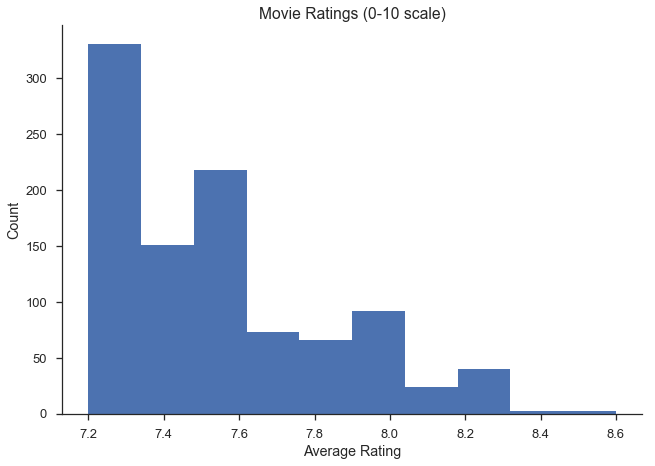

In [5]:
plt.hist(movies.vote_average)
plt.title('Movie Ratings (0-10 scale)')
plt.xlabel('Average Rating')
plt.ylabel('Count')
sns.despine()

### Total Counts of TMDB Genres in Dataset

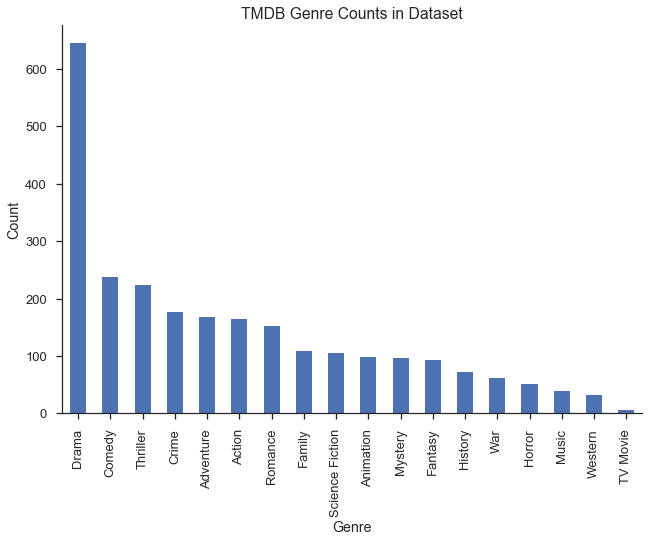

In [6]:
genre_list_ints = []
for sublist in list(movies.tmdb_genres):
    for item in sublist:
        genre_list_ints.append(item)

genre_list_strings = []
for genre in genre_list_ints:
    genre_list_strings.append(id_to_genre[genre])
    
genre_counts = Counter(genre_list_strings)
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index')
genre_df.sort_values(by = 0, ascending=False).plot(kind='bar', legend=False)
plt.title('TMDB Genre Counts in Dataset')
plt.ylabel('Count')
plt.xlabel('Genre')
sns.despine()

### Count by Movie of Total TMDB & IMDB Genre Labels in Dataset

Average TMDB Genres: 2.5355355355355353


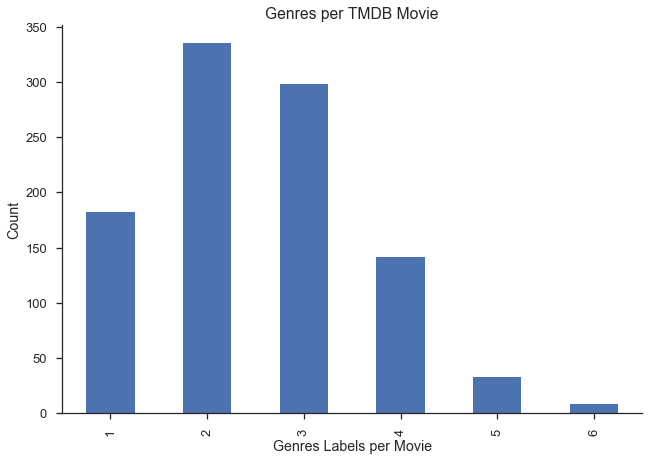

In [7]:
#count number of genres per movie
tmdb_num_genres_per_movie = [len(genres) for genres in movies.tmdb_genres]

#collect counts and plot for both imdb and tmdb
tmdb_num_genre_counts = Counter(tmdb_num_genres_per_movie)
tmdb_genre_counts_df = pd.DataFrame.from_dict(tmdb_num_genre_counts, orient='index')
tmdb_genre_counts_df = tmdb_genre_counts_df.sort_index()
tmdb_genre_counts_df.plot(kind='bar', legend=False)
plt.title('Genres per TMDB Movie')
plt.xlabel('Genres Labels per Movie')
plt.ylabel('Count')
sns.despine()

print('Average TMDB Genres:', np.mean(tmdb_num_genres_per_movie))

### Counts of Movie Release Years in Dataset

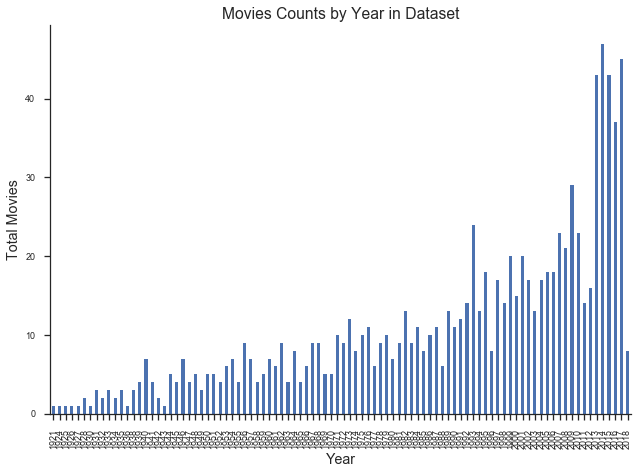

In [8]:
movie_years = [year.year for year in movies.release_date]
year_counts = Counter(movie_years)
year_df = pd.DataFrame.from_dict(year_counts, orient='index')
year_df.sort_index().plot(kind='bar', legend=False)
plt.title('Movies Counts by Year in Dataset')
plt.tick_params(labelsize=9)
plt.ylabel('Total Movies')
plt.xlabel('Year')
sns.despine()

### Distribution of TMDB & IMDB Plot Lengths

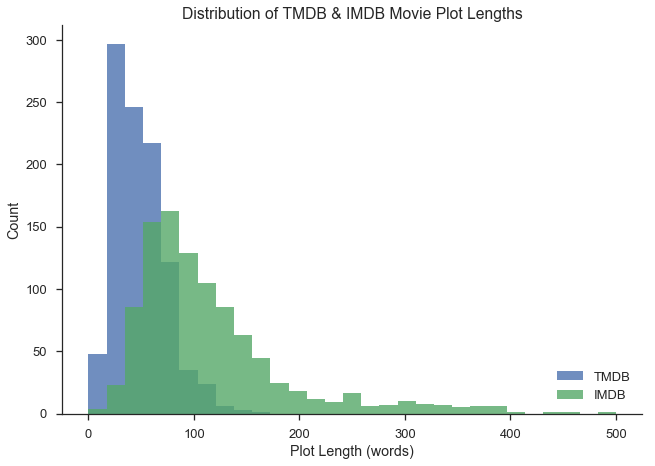

In [9]:
#tmdb lengths
tmdb_plot_lengths = []
for plot in movies.tmdb_plot:
    plot_length = len(plot.split())
    tmdb_plot_lengths.append(plot_length)
    
#imdb lengths
imdb_plot_lengths = []
for plot in movies.imdb_plot:
    plot_length = len(plot.split())
    imdb_plot_lengths.append(plot_length)
    
#plot tmdb lengths
bins = np.linspace(0, 500, 30)
plt.hist(tmdb_plot_lengths, bins, alpha = 0.8, label = 'TMDB')
plt.hist(imdb_plot_lengths, bins, alpha = 0.8, label = 'IMDB')
plt.xlabel('Plot Length (words)')
plt.ylabel('Count')
plt.title('Distribution of TMDB & IMDB Movie Plot Lengths')
plt.legend(loc='lower right')
sns.despine();

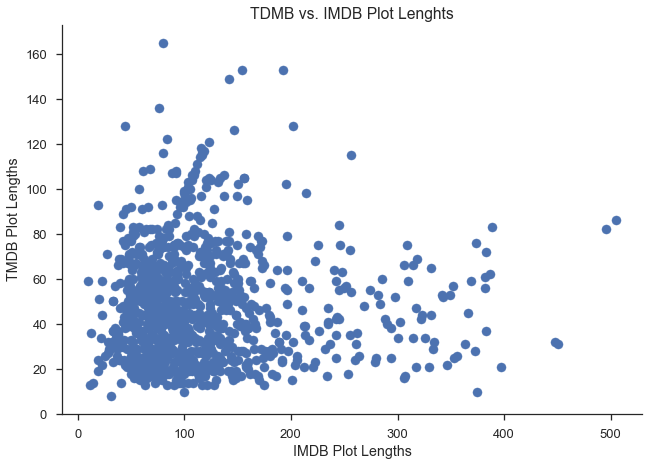

In [10]:
#scatter of TMDB vs IMDB plot lengths
plt.scatter(imdb_plot_lengths, tmdb_plot_lengths)
plt.title('TDMB vs. IMDB Plot Lenghts')
plt.xlabel('IMDB Plot Lengths')
plt.ylabel('TMDB Plot Lengths')
sns.despine();

#### More plot length metrics

In [11]:
print('Shortest and longest plots (words):')
print('TMDB: ', min(tmdb_plot_lengths),',', max(tmdb_plot_lengths))
print('Mean TMDB plot length:', np.mean(tmdb_plot_lengths))
print()
print('IMDB: ', min(imdb_plot_lengths),',', max(imdb_plot_lengths))
print('Mean IMDB plot length:', np.mean(imdb_plot_lengths))


Shortest and longest plots (words):
TMDB:  8 , 165
Mean TMDB plot length: 48.474474474474476

IMDB:  10 , 505
Mean IMDB plot length: 115.35035035035035


### Plot Lengths vs. Number of Genres per Movie

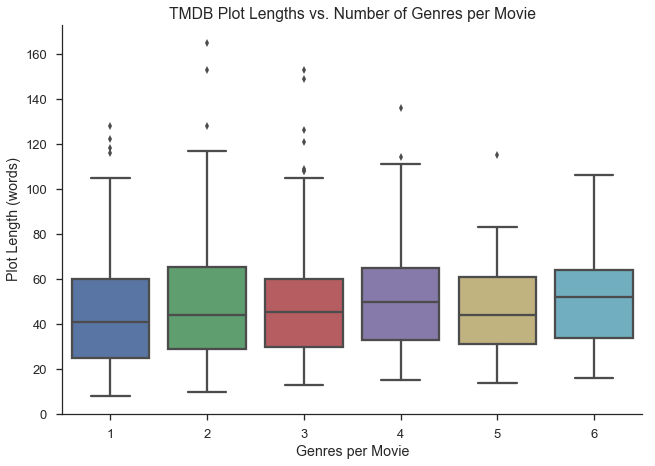

In [12]:
sns.boxplot(tmdb_num_genres_per_movie, tmdb_plot_lengths)
plt.title('TMDB Plot Lengths vs. Number of Genres per Movie')
plt.xlabel('Genres per Movie')
plt.ylabel('Plot Length (words)')
sns.despine()

---
# Bag-of-words transformations of our TMDB, IMDB, and combined movie plots


### Make a new feature of combined TMDB and IMDB plots
We will make a new column with the combined plots of tmdb and imdb. Perhaps this will offer a richer representation of each plot and increase our precision and recall in the forthcoming modeling.

In [13]:
movies['combined_plots'] = movies['tmdb_plot'] + ' ' + movies['imdb_plot']

---
### Apply Count Vectorize and TFIDF to Plots

Sklearn's TfidfVectorizer will apply both a count vectorizer and Term Frequency Inverse Document Frequency (TFIDF) transformation to our plots. The count vectorizer will convert our collection of plots into a matrix of word counts. We set max_df and min_df to ignore words specific to our corpus of movie plots that occur both a lot and few times, and we also ignore english stop words if the previous arguments missed some. The TFIDF transformation will essentially apply a rarity score to each word returning a normalized TFIDF matrix for each feature - TMDB, IMDB, and combined plots.

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.005, 
                          stop_words = get_stop_words('en'))

tmdb_bow=tfidf_vectorizer.fit_transform(movies['tmdb_plot'])
imdb_bow=tfidf_vectorizer.fit_transform(movies['imdb_plot'])
combined_bow = tfidf_vectorizer.fit_transform(movies['combined_plots'])

#check shape of resulting matrices
tmdb_bow.shape, imdb_bow.shape, combined_bow.shape

C:\Users\A706GZZ\Documents\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


((999, 1162), (999, 2436), (999, 3022))

As seen above, now each TMDB and IMDB movies are represented by an 1171 and 2439 length array, and each combined plot is a 3025 length array, respectively. Each number in the array is the associated TFIDF score for the count vectorized representation of each plot. Most of the array values will be zero since each movie has on average 50 and 100 words for TMDB and IMDB, respectively.

---

### Add Bag-of-Words Matrices to Movies DF and save

We cast the resulting arrays into lists that pandas can save in a nice fashion for when we import in the modeling and analysis notebook. We also save them as numpy arrays for easier importing.

In [15]:
#each plot is a row vector of the TFIDF sparse matrices
movies['tmdb_bow_plot'] = [plot for plot in tmdb_bow]
movies['imdb_bow_plot'] = [plot for plot in imdb_bow]
movies['combined_bow_plots'] = [plot for plot in combined_bow]

#resave movies csv
movies.to_csv('data/movies.csv', encoding="utf-8", index=False)

#save TFIDF matrices an numpy arrays
np.save('data/tmdb_bow.npy',tmdb_bow.toarray())
np.save('data/imdb_bow.npy',imdb_bow.toarray())
np.save('data/combined_bow.npy', combined_bow.toarray())

### We have now transformed and saved each plot as a bag-of-words TFIDF representation.
---
# Word2vec transformation of our TMDB, IMDB, and combined movie plots
---
#### Clean plots

In [16]:
#define tokenizer
tokenizer = RegexpTokenizer(r'\w+')
#set stop words list
english_stop = get_stop_words('en')
print(len(english_stop))

#function to clean plots
def clean_plot(plot):
    '''
    clean_plot()
    -applies the following the plot of a movie:
        1) lowers all strings
        2) tokenizes each word
        3) removed English stop words

    -inputs: plot (string)
    
    -outputs: list representation of plot
    '''
    plot = plot.lower()
    plot = tokenizer.tokenize(plot)
    plot = [word for word in plot if word not in english_stop]
    return plot

174


In [17]:
#check function on first movie's clean plot
print(movies.tmdb_plot[0])
print(clean_plot(movies.tmdb_plot[0]))

Framed in the 1940s for the double murder of his wife and her lover  upstanding banker Andy Dufresne begins a new life at the Shawshank prison  where he puts his accounting skills to work for an amoral warden  During his long stretch in prison  Dufresne comes to be admired by the other inmates    including an older prisoner named Red    for his integrity and unquenchable sense of hope 
['framed', '1940s', 'double', 'murder', 'wife', 'lover', 'upstanding', 'banker', 'andy', 'dufresne', 'begins', 'new', 'life', 'shawshank', 'prison', 'puts', 'accounting', 'skills', 'work', 'amoral', 'warden', 'long', 'stretch', 'prison', 'dufresne', 'comes', 'admired', 'inmates', 'including', 'older', 'prisoner', 'named', 'red', 'integrity', 'unquenchable', 'sense', 'hope']


---
#### Apply clean_plots() function to TMDB, IMDB, and combined plots

In [18]:
#apply to movies df for both imdb and tmdb
movies['tmdb_clean_plot'] = movies['tmdb_plot'].apply(lambda x: clean_plot(x))
movies['imdb_clean_plot'] = movies['imdb_plot'].apply(lambda x: clean_plot(x))
movies['combined_clean_plot'] = movies['combined_plots'].apply(lambda x: clean_plot(x))

#check some outputs
movies.tmdb_clean_plot[1:5], movies.imdb_clean_plot[1:5], movies.combined_clean_plot[1:5]

(1    [spanning, years, 1945, 1955, chronicle, ficti...
 2    [true, story, businessman, oskar, schindler, s...
 3    [continuing, saga, corleone, crime, family, yo...
 4    [burger, loving, hit, man, philosophical, part...
 Name: tmdb_clean_plot, dtype: object,
 1    [aging, head, famous, crime, family, decides, ...
 2    [oskar, schindler, vainglorious, greedy, germa...
 3    [continuing, saga, corleone, crime, family, te...
 4    [jules, winnfield, samuel, l, jackson, vincent...
 Name: imdb_clean_plot, dtype: object,
 1    [spanning, years, 1945, 1955, chronicle, ficti...
 2    [true, story, businessman, oskar, schindler, s...
 3    [continuing, saga, corleone, crime, family, yo...
 4    [burger, loving, hit, man, philosophical, part...
 Name: combined_clean_plot, dtype: object)

---
#### Apply word2vec Transformation of Plots

For this transformation we will use the Google News pretrained word2vec model ([link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)) that was trained on a more than 3 billion word corpus. It contains 3 million words, each represented by a 300-dimension vector. We make a couple of design choices for how we transform our movie plots:

- If a word in the cleaned plots (lowered, punctuation and stop word dropped, tokenized) is in the word2vec model, add it to a running list for that plot.
- If a word is not in the word2vec model, skip it. We print some of these words below for example.
- We then take two different representations for each plot. One as a matrix where each row is a 300-dimension representation of a particular word in the plot, and a column-wise mean vector, where each plot is reduced to 1x300 dimension array.

The assumption we make by taking the mean of each plot is that the resulting 300-dimension vector will point in the direction of one or more genres, but we acknowledge that it will most likely reduce some of the semantic value of certain words.


In [19]:
#Load the pretrained google news word2vec model
model = models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [20]:
#collect words not in the Google News w2v model
not_w2v = []

#word2vec function
def apply_words2Vec(cleaned_plot, mean=False):
    
    """
    apply_words2Vec()
    -applies the following transformations to the cleaned plot of a movie:
        1) removes words that are not in google's model
        2) creates a 300-dimension vector representation of each word
        3) outputes vector of vectors for plot
        If mean = True
        4) converts the resulting nd_array into a 1d_array via np.mean() and
           outputs single vector for each plot.
    -also keeps track of all words not found in google's model
    
    -inputs: cleaned_plot (string)
    
    -outputs: vector representation of plot
    
    """
    vecs=[]
    for word in cleaned_plot:
        #add word vector to list if it is in the google model
        try:
            vecs.append(model.word_vec(word)) 
        except:
            #if the word is not in the w2v model, add it to
            #our list of skipped words
            not_w2v.append(word)
    
    #take the column-wise mean of vecs to reduce nd_aray to 1d_array
    if mean == True:
        vecs = np.mean(vecs, axis=0)
        return vecs
    #return matrix of w2v arrays where each row is a word in the plot
    return np.stack(vecs)

In [21]:
#apply transformation to three sets of plots and add columns to df

#columns with mean w2v
movies['tmdb_w2v_plot_mean'] = movies['tmdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=True))
movies['imdb_w2v_plot_mean'] = movies['imdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=True))
movies['combined_w2v_plot_mean'] = movies['combined_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=True))

#columns with w2v matrix for each plot
movies['tmdb_w2v_plot_matrix'] = movies['tmdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=False))
movies['imdb_w2v_plot_matrix'] = movies['imdb_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=False))
movies['combined_w2v_plot_matrix'] = movies['combined_clean_plot'].apply(lambda x: apply_words2Vec(x, mean=False))

#check shapes of first movie vectors to confirm nd_array and 300-dimensions
print('Mean vector representations:')
print(movies.loc[0,'tmdb_w2v_plot_mean'].shape, 
      movies.loc[0,'imdb_w2v_plot_mean'].shape, 
      movies.loc[0, 'combined_w2v_plot_mean'].shape)

print('Matrix representations:')
print(movies.loc[0,'tmdb_w2v_plot_matrix'].shape, 
      movies.loc[0,'imdb_w2v_plot_matrix'].shape,
      movies.loc[0,'combined_w2v_plot_matrix'].shape)

Mean vector representations:
(300,) (300,) (300,)
Matrix representations:
(33, 300) (38, 300) (71, 300)


Each TMDB and IMDB plot has been transformed into a 300-dimension representation of that plot, as well as an matrix where each row represents a word in the plot. We will use these features as predictors in our multi-lable classification modeling.

In [22]:
#print some of our skipped words
print(len(not_w2v))
np.random.seed(112)
print(np.random.choice(not_w2v, 50, replace=False))

21532
['deray' 'janeiro' 'verona' 'calloway' 'ferrante' 'griswolds' 'chiyo'
 'beaufort' 'brubaker' 'nitesh' 'lightyear' 'carvalho' 'manolo' 'onllwyn'
 'altaira' 'mulan' 'barrelled' 'nicodemus' '2009' 'emmett' 'claudio'
 'margo' 'pleakley' 'liesel' 'wwii' '04' 'claudio' 'saoirse' 'cristo'
 'augustine' 'chiyo' 'agu' 'connery' 'zakone' '60s' 'doris' 'thao' '21'
 'ultron' 'costillo' 'moonee' 'zorg' 'saroo' '60' 'clarice' 'matuschek'
 'a24' 'wigand' 'standish' '1327']


There are 21,532 words in our cleaned TMDB and IMDB plots that were skipped when applying the word2vec transformation (many are repeats due to combined plots). As seen above, the random sample of 50 of those words are mostly years, numbers, and proper nouns. This is not surprising, and we suspect will not have a large impact on the resulting word2vec representations of our movie plots.

---

#### Check that each plot has a corresponding word2vec representation
If both TMDB and IMDB have mean representations, we can assume the combined and matrix representations are also filled.

In [23]:
for plot in movies.tmdb_w2v_plot_mean:
    if len(plot) != 300:
        print("AH! no word2vec representation")
print('All TMDB movies have a word2vec representation.')

for plot in movies.imdb_w2v_plot_mean:
    if len(plot) != 300:
        print("AH! no word2vec representation")
print('All IMDB movies have a word2vec representation.')

All TMDB movies have a word2vec representation.
All IMDB movies have a word2vec representation.


---
**Save w2v data as a numpy arrays/matrices for further modeling and analysis**

In [24]:
#w2v mean vectors
np.save('data/tmdb_w2v_mean.npy', movies['tmdb_w2v_plot_mean'].as_matrix())
np.save('data/imdb_w2v_mean.npy', movies['imdb_w2v_plot_mean'].as_matrix())
np.save('data/combined_w2v_mean.npy', movies['combined_w2v_plot_mean'].as_matrix())

#w2v matrices
np.save('data/tmdb_w2v_matrix.npy', movies['tmdb_w2v_plot_matrix'].as_matrix())
np.save('data/imdb_w2v_matrix.npy', movies['imdb_w2v_plot_matrix'].as_matrix())
np.save('data/combined_w2v_matrix.npy', movies['combined_w2v_plot_matrix'].as_matrix())

---
#### Update and save DataFrame for future analysis

In [25]:
movies.to_csv('data/movies.csv', encoding="utf-8", index=False)

### We have now transformed and saved each plot as a 300-dimension vector and n_words x 300 dimension matrix word2vec representation.
---
# Doc2Vec transformation of our TMDB, IMDB, and combined movie plots
---
#### Using cleaned plots above

#### Transform Plots into TaggedDocument objects

In order to use gensim's Doc2Vec model, we must first transform each plot into a TaggedDocument object.

In [26]:
#turn plots into TaggedDocuments
#apply to movies df for imdb, tmdb, and combined
cols = ['tmdb_clean_plot', 'imdb_clean_plot', 'combined_clean_plot']
n_cols = ['tmdb_tag_docs', 'imdb_tag_docs', 'combined_tag_docs']
for ncol, col in zip(n_cols, cols):
    acc = []
    for i, plot in enumerate(movies[col]): 
        z = models.doc2vec.TaggedDocument(words=plot, tags=[str(i)])
        acc.append(z)
    movies[ncol] = acc
movies['tmdb_tag_docs'][:1]

0    ([framed, 1940s, double, murder, wife, lover, ...
Name: tmdb_tag_docs, dtype: object

#### Train Doc2Vec models 

Next we train Doc2Vec models on each set of plots. We selected a vector size of 19, because there are 19 possible genres. Since we are only concerned with document vectors we set dm=0, so that the model does not get word vectors as well and training goes faster. Finally, because we are using a relatively small dataset we set epochs=20 so that our models don't overfit.

In [28]:
cols = ['tmdb_tag_docs', 'imdb_tag_docs', 'combined_tag_docs']
n_cols = ['tmdb_doc_vec', 'imdb_doc_vec', 'combined_doc_vec']
for ncol, col in zip(n_cols, cols):
    model = models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.001, vector_size=19, dm=0, window=5)
    model.build_vocab(movies[col])
    model.train(movies[col], total_examples=999, epochs=20)
    movies[ncol] = [model.docvecs[x] for x in range(999)]
    
movies['combined_doc_vec'][0]

array([ 0.0968614 , -0.46652728, -0.45317551, -0.14719348, -0.01199048,
       -0.00980508,  0.42810196, -0.8017472 , -0.80489886, -0.38724148,
       -0.41264883, -0.13820013, -0.07433534,  0.76347977,  0.03485315,
       -0.68056315, -0.19607563, -0.18498695,  0.17611814], dtype=float32)

Now each plot is represented by a (1,19) vector, so we save these.

In [29]:
np.save('data/tmdb_doc_vec.npy', movies['tmdb_doc_vec'].as_matrix())
np.save('data/imdb_doc_vec.npy', movies['imdb_doc_vec'].as_matrix())
np.save('data/combined_doc_vec.npy', movies['combined_doc_vec'].as_matrix())